In [1]:
import ims
import matplotlib.pyplot as plt
print(ims.__version__)

0.1.7


# 1. IMPORT E INFO CAMPIONI 

In [2]:
#prefisso r: per ottenere una stringa grezza, se non fosse una stringa grezza avrei dovuto mettere come separatore \\.
#Copiare percorso

path = r"C:\Users\spatafran1\GC-IMS Data\Batch_4 - NOVEMBER"

ds = ims.Dataset.read_mea(path, subfolders=True)
ds


Dataset: Batch_4 - NOVEMBER, 15 Spectra

In [3]:
#INFO CAMPIONI

    #indici di ogni campione: 0,1,2...
#ds.sample_indices
    #classi/etichette di ogni campione (saranno usate per PCA, OPLS)
#ds.labels
    #nome campioni 
#ds.samples

In [4]:
# STAMPA E SALVA SPETTRI
#scala colore: se scala colori incorretta modificare valore vmax

    #per salvare singolo spettro come .png
#ds[12].plot(vmax=1000)
#plt.savefig("test.png", dpi=300, bbox_inches="tight")

    #per salvare tutti gli spettri come .png
#for sample in ds:
 #sample.plot(vmax=1000)
    #plt.savefig(f"{sample.name}.png", dpi=300, bbox_inches="tight")
  
    #per stampare tutte le figure 
#for sample in ds:
   #sample.plot(vmax=1000)

# 2. PRE-PROCESSING
Binning;
Allineamento RI;
Cut_RT e cut_DT
Allineamento RT: consigliato per sequenze diverse;
Scaling

(<Figure size 600x600 with 2 Axes>,
 <Axes: title={'center': '4000_DarkChoc_27-11-23_EC_ARRIBA_500-1191_batch24174_1'}, xlabel='Drift time RIP relative', ylabel='Retention time [s]'>)

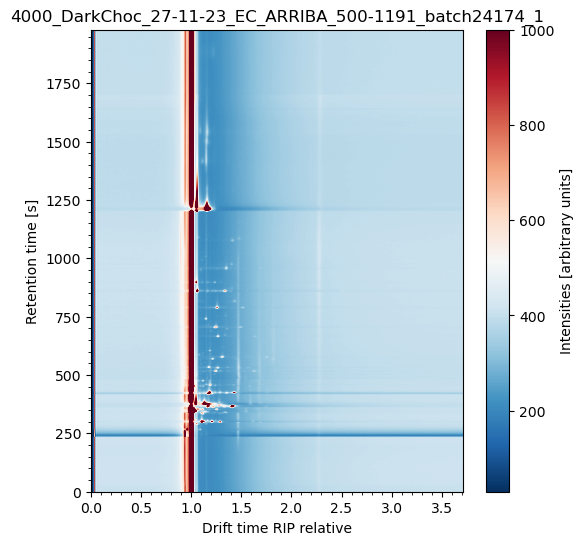

In [5]:
#step 1 BINNING=2 reccomended
#step 2 INTERP_RIPREL (allineamento per RIP)
ds.binning(2).interp_riprel()
ds[0].plot(vmax=1000)

(<Figure size 600x600 with 2 Axes>,
 <Axes: title={'center': '4000_DarkChoc_27-11-23_EC_ARRIBA_500-1191_batch24174_1'}, xlabel='Drift time RIP relative', ylabel='Retention time [s]'>)

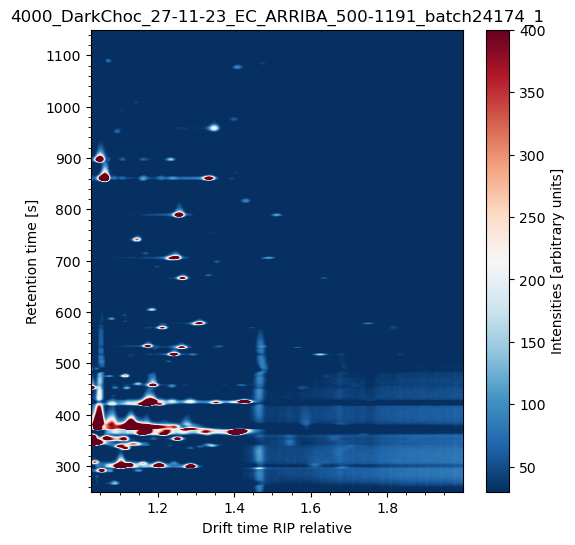

In [6]:
#step 3 CUT_DT
#step 4 CUT_RT 
ds.cut_dt(1.025, 2.0).cut_rt(250, 1150).asymcorr()
ds[0].plot()

In [7]:
#step 5 RT alignment: consigliato solo per allineare sequenze diverse

#ds.align_ret_time()
#ds[0].plot(vmax=1000)

In [8]:
#step 6 scaling 
#"pareto", "auto" or "var" are valid
#per ottenere un valore unico medio per ogni classe ds.mean().scaling("pareto")
ds.scaling("pareto", mean_centering=True)

Dataset: Batch_4 - NOVEMBER, 15 Spectra

# 3. PROCESSING - MULTIVARIATE ANALYSIS 
PCA (scree_plot, Q_plot);
HCA;
OPLS-DA

In [9]:
# x=samples, y=variables)
X, y = ds.get_xy()

print(X.shape)
print(y.shape)


(15, 1267668)
(15,)


<Axes: title={'center': 'PCA loadings of PC 1 (70.3 % of variance)'}, xlabel='Drift time RIP relative', ylabel='Retention time [s]'>

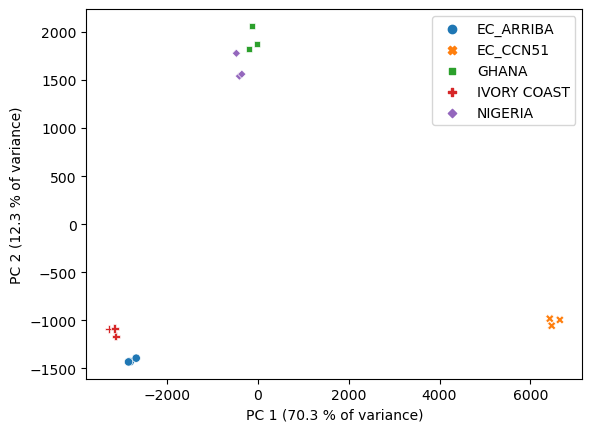

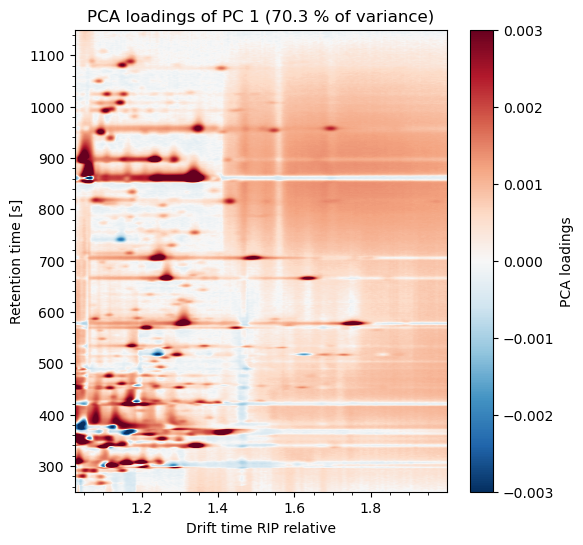

In [10]:
# per PCA selezionare n_components
pca = ims.PCA_Model(ds, n_components=8)
pca.fit(X)
pca.plot(1, 2)
pca.plot_loadings(1, color_range=0.003)
#se cattiva visualizzazione cambiare scala colore in color_range

<Axes: xlabel='Principal component', ylabel='Explainded variance ratio [%]'>

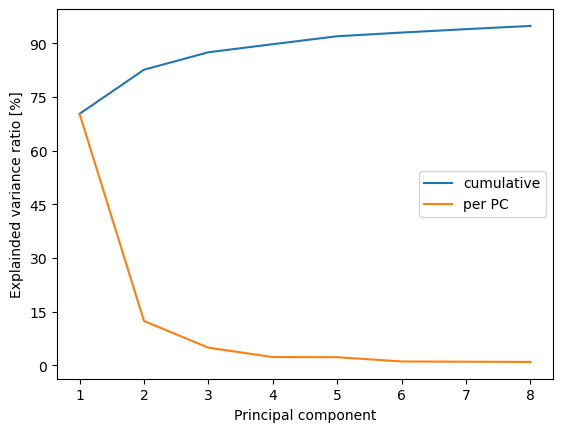

In [11]:
pca.scree_plot()

<Axes: xlabel='Q', ylabel='$T^2$'>

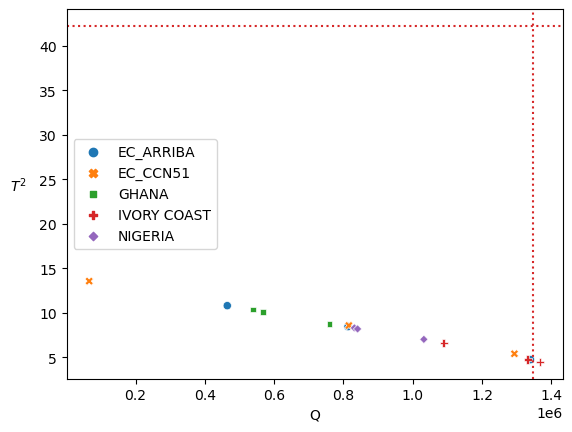

In [12]:
pca.Tsq_Q_plot()

<Axes: xlabel='Distances (euclidean method)'>

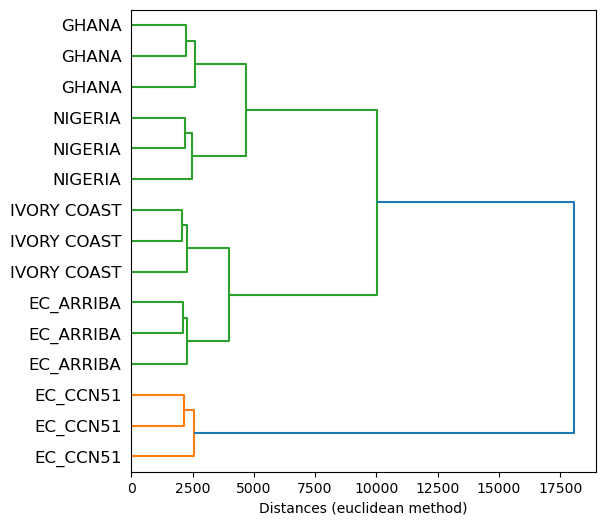

In [13]:
hca = ims.HCA(ds, linkage="ward", affinity="euclidean")
hca.fit(X)
hca.plot_dendrogram(orientation="right")


<Axes: title={'center': 'PLS-DA loadings of component 1'}, xlabel='Drift time RIP relative', ylabel='Retention time [s]'>

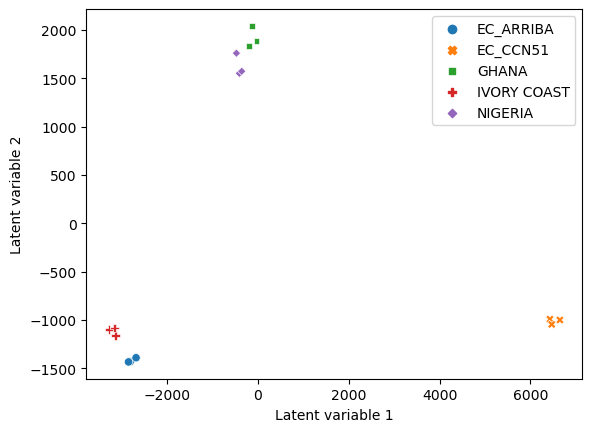

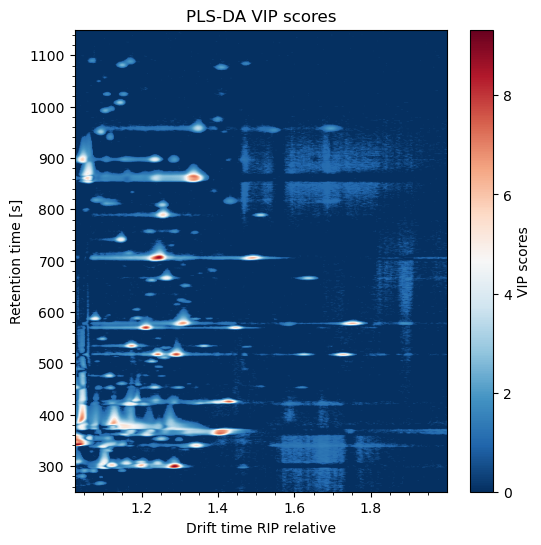

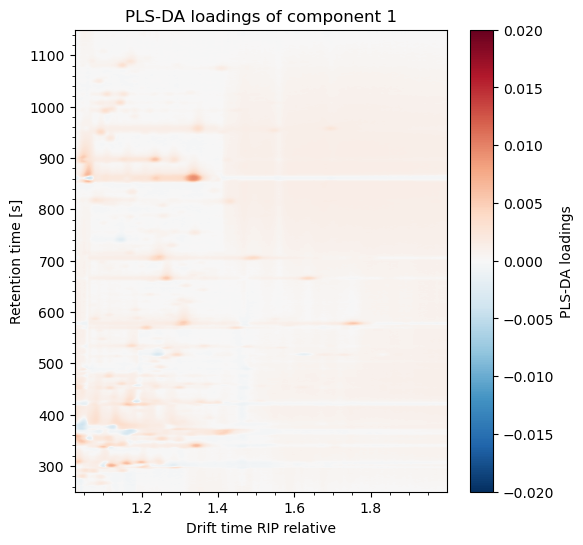

In [14]:
plsda = ims.PLS_DA(ds, n_components=3)
plsda.fit(X,y)
plsda.plot(1,2)
plsda.plot_vip_scores(threshold=1)
plsda.plot_loadings(1)
#plsda.plot_coefficients(group=1, width=6, height=6)
#per impostare treshold VIP: plsda.plot_vip_scores(threshold=1)

# 4. VALIDATION
test-set vs. training-set;
confusion martrix

In [15]:
#training set-test set: 
#test size: dovrebbe essere pari al numero di classi
X_train, X_test, y_train, y_test = ds.train_test_split(stratify=True, test_size=5)

<Axes: title={'center': 'PLS-DA VIP scores'}, xlabel='Drift time RIP relative', ylabel='Retention time [s]'>

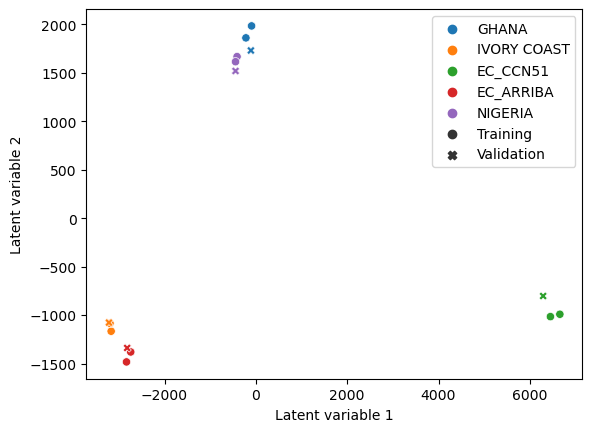

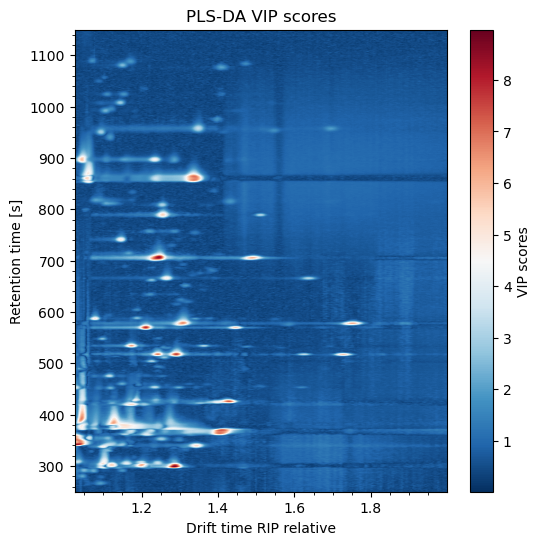

In [16]:
#PLS-DA training set-test set
plsda = ims.PLS_DA(ds, n_components=3)
plsda.fit(X_train,y_train)
plsda.predict(X_test)
plsda.plot()
plsda.plot_vip_scores()

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
import numpy as np
accuracy = []
precision = []
pred = np.array([])
test = np.array([])

In [18]:
#setting: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
for X_train, X_test, y_train, y_test in ds.kfold_split(shuffle=True):
        plsda.fit(X_train, y_train)
        y_pred = plsda.predict(X_test)
        pred = np.append(pred,y_pred)
        test = np.append(test,y_test)
        acc = plsda.score(X_test,y_test)
        accuracy.append(acc)
        pr = precision_score(y_test, y_pred, average='weighted')
        precision.append(pr)

0.8666666666666666
0.8666666666666666
['EC_ARRIBA' 'EC_CCN51' 'NIGERIA' 'EC_ARRIBA' 'EC_CCN51' 'GHANA' 'GHANA'
 'IVORY COAST' 'NIGERIA' 'EC_ARRIBA' 'GHANA' 'NIGERIA' 'EC_CCN51'
 'EC_ARRIBA' 'EC_ARRIBA']


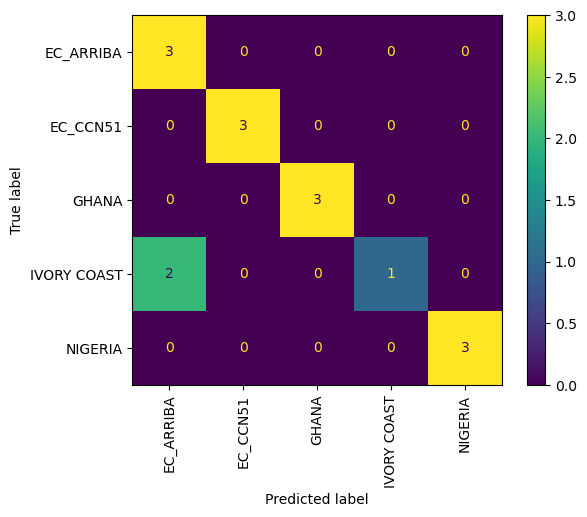

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(np.mean(accuracy))
print(np.mean(precision))
print(pred)
label_names = np.unique(ds.labels)
cm = confusion_matrix(test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot( xticks_rotation="vertical")
plt.show()